# Controller vs Controller Comparison

This notebook compares NR/NR Enhanced control against NMPC control across different trajectories.

**Structure:**
- Separate sections for Simulation and Hardware
- Top row: NR or NR Enhanced trajectories
- Bottom row: NMPC trajectories
- Matched trajectories for easy comparison
- Automatic 2D plane detection per trajectory

**Trajectories:**
- Horizontal Circle (Circle A)
- Vertical Circle (Circle B)
- Horizontal Lemniscate (Lemniscate A)
- Vertical Short Lemniscate (Lemniscate B)
- Vertical Tall Lemniscate (Lemniscate C)
- Regular Helix (Helix A)
- Yawing Helix (Helix B)
- Yawing Horizontal Circle (Circle C)

## 1. Import Libraries

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Import utilities
from utilities import (
    load_all_csvs,
    extract_metadata_from_data,
    detect_trajectory_plane,
    plot_trajectory_2d,
    calculate_position_rmse,
    align_reference_to_actual,
    PLATFORM_NAMES,
    CONTROLLER_NAMES,
    TRAJECTORY_NAMES
)

# Use default matplotlib style (white background)
plt.style.use('default')

# Font and figure settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'EB Garamond', 'EB Garamond 12', 'Liberation Sans', 'Arial']

## 2. Configuration

**Choose which NR controller to compare against NMPC:**
- `'NR Standard'` (controller enum 0)
- `'NR Enhanced'` (controller enum 1)

In [67]:
# ===== CONFIGURATION =====
NR_CONTROLLER_CHOICE = 'NR Enhanced'  # <-- Change to 'NR Standard' or 'NR Enhanced'

# Plot styling
subfigure_title_fontsize = 14
tick_size = 10
show_gridlines = False  # <-- Set to False to remove gridlines
# =========================

# Path to log files directory
logs_path = "log_files/"

# Output directory for figures
output_path = "output/"
os.makedirs(output_path, exist_ok=True)

print(f"Configuration:")
print(f"  NR Controller: {NR_CONTROLLER_CHOICE}")
print(f"  Comparing against: MPC")
print(f"  Log files: {logs_path}")
print(f"  Output: {output_path}")
print(f"  Gridlines: {'On' if show_gridlines else 'Off'}")

Configuration:
  NR Controller: NR Enhanced
  Comparing against: MPC
  Log files: log_files/
  Output: output/
  Gridlines: Off


## 3. Load and Organize Data

In [68]:
# Load all CSV files
data_dict = load_all_csvs(logs_path)

print(f"Loaded {len(data_dict)} CSV files")

# Organize data by platform, controller, and trajectory
organized_data = {
    'Simulation': {
        NR_CONTROLLER_CHOICE: {},
        'MPC': {}
    },
    'Hardware': {
        NR_CONTROLLER_CHOICE: {},
        'MPC': {}
    }
}

# Process each file and organize by platform/controller/trajectory
for filename, df in data_dict.items():
    metadata = extract_metadata_from_data(df)
    
    platform = metadata['platform']
    controller = metadata['controller']
    trajectory = metadata['trajectory']
    
    # Skip if platform or controller not recognized
    if platform not in organized_data:
        continue
    if controller not in organized_data[platform]:
        continue
    
    # Store the dataframe
    organized_data[platform][controller][trajectory] = {
        'df': df,
        'filename': filename,
        'metadata': metadata
    }

# Print summary
print("\nData Organization:")
print("=" * 60)
for platform in ['Simulation', 'Hardware']:
    print(f"\n{platform}:")
    for controller in [NR_CONTROLLER_CHOICE, 'MPC']:
        n_traj = len(organized_data[platform][controller])
        print(f"  {controller}: {n_traj} trajectories")
        if n_traj > 0:
            for traj_name in organized_data[platform][controller].keys():
                print(f"    - {traj_name}")

Loaded 33 CSV files

Data Organization:

Simulation:
  NR Enhanced: 7 trajectories
    - Circle V
    - Fig8 VT
    - Circle H
    - Triangle
    - Sawtooth
    - Fig8 H
    - Fig8 VS
  MPC: 7 trajectories
    - Triangle
    - Fig8 VT
    - Fig8 VS
    - Fig8 H
    - Circle V
    - Sawtooth
    - Circle H

Hardware:
  NR Enhanced: 7 trajectories
    - Fig8 H
    - Fig8 VS
    - Fig8 VT
    - Sawtooth
    - Circle V
    - Triangle
    - Circle H
  MPC: 7 trajectories
    - Fig8 VS
    - Circle H
    - Fig8 VT
    - Fig8 H
    - Circle V
    - Triangle
    - Sawtooth


## 4. Define Trajectory Mapping

Map internal trajectory names to publication names.

In [69]:
# Trajectory name mapping (internal name -> publication name)
# Only including: Circle A, B, Lemniscates A, B, C, Sawtooth, and Triangle
TRAJECTORY_MAP = {
    'Circle H': 'Circle A',          # Horizontal Circle
    'Circle V': 'Circle B',          # Vertical Circle
    'Fig8 H': 'Lemniscate A',        # Horizontal Lemniscate (Figure-8)
    'Fig8 VS': 'Lemniscate B',       # Vertical Short Lemniscate
    'Fig8 VT': 'Lemniscate C',       # Vertical Tall Lemniscate
    'Sawtooth': 'Sawtooth',          # Sawtooth
    'Triangle': 'Triangle',          # Triangle
}

# Trajectories to include in plots (filter out others)
INCLUDED_TRAJECTORIES = set(TRAJECTORY_MAP.keys())

def get_publication_name(trajectory: str, metadata: dict) -> str:
    """
    Get publication name for trajectory.
    Returns None if trajectory should be excluded.
    """
    # Only include trajectories in our map
    if trajectory not in TRAJECTORY_MAP:
        return None
    
    return TRAJECTORY_MAP[trajectory]

print("Included Trajectories:")
for internal, pub in TRAJECTORY_MAP.items():
    print(f"  {internal} -> {pub}")

    

Included Trajectories:
  Circle H -> Circle A
  Circle V -> Circle B
  Fig8 H -> Lemniscate A
  Fig8 VS -> Lemniscate B
  Fig8 VT -> Lemniscate C
  Sawtooth -> Sawtooth
  Triangle -> Triangle


## 5. Helper Functions

In [70]:
def plot_controller_comparison_grid(platform_data: dict, 
                                   nr_controller: str,
                                   trajectory_order: List[str],
                                   platform_name: str,
                                   figsize: Tuple[int, int] = (20, 8),
                                   title_fontsize: int = 14,
                                   tick_fontsize: int = 10,
                                   show_grid: bool = True):
    """
    Create a 2-row comparison grid for a single platform.
    
    Parameters:
    -----------
    platform_data : dict
        Dictionary with controller -> trajectory -> data structure
    nr_controller : str
        Name of NR controller ('NR Standard' or 'NR Enhanced')
    trajectory_order : list
        Ordered list of trajectory names to display
    platform_name : str
        'Simulation' or 'Hardware'
    figsize : tuple
        Figure size
    title_fontsize : int
        Font size for subplot titles
    tick_fontsize : int
        Font size for tick labels
    show_grid : bool
        Whether to show gridlines
    """
    n_trajectories = len(trajectory_order)
    
    if n_trajectories == 0:
        print(f"No trajectories to plot for {platform_name}")
        return None
    
    # Create figure with 2 rows (NR on top, MPC on bottom)
    fig, axes = plt.subplots(2, n_trajectories, figsize=figsize, squeeze=False)
    
    controllers = [nr_controller, 'MPC']
    controller_labels = [nr_controller, 'NMPC']
    
    # Counter for subfigure labels (a, b, c, ...)
    subplot_counter = 0
    
    for row_idx, (controller, controller_label) in enumerate(zip(controllers, controller_labels)):
        for col_idx, traj_name in enumerate(trajectory_order):
            ax = axes[row_idx, col_idx]
            
            # Get subfigure label (a, b, c, ...)
            subplot_label = chr(ord('a') + subplot_counter)
            subplot_counter += 1
            
            # Get data for this trajectory and controller
            if traj_name in platform_data[controller]:
                data_info = platform_data[controller][traj_name]
                df = data_info['df']
                metadata = data_info['metadata']
                
                # Apply NED to ENU conversion and alignment
                df_plot = df.copy()
                df_plot['z'] = -df_plot['z']
                df_plot['z_ref'] = -df_plot['z_ref']
                df_plot = align_reference_to_actual(df_plot, sampling_rate=10.0)
                
                # Detect plane for this trajectory
                plane = detect_trajectory_plane(df_plot)
                
                # Plot with custom colors (RED for actual, BLUE dashed for reference)
                plot_trajectory_2d(ax, df_plot, plane=plane, 
                                 actual_color='red', ref_color='blue',
                                 actual_label='Actual', ref_label='Reference',
                                 flip_z=False, align_lookahead=False)  # Already done above
                
                # Remove legend (not needed in subplots)
                legend = ax.get_legend()
                if legend is not None:
                    legend.remove()
                
                # Control gridlines (override utilities.py default)
                if show_grid:
                    ax.grid(True, alpha=0.3)
                else:
                    ax.grid(False)
                
                # Calculate RMSE (flip_z=False because we already flipped)
                rmse = calculate_position_rmse(df_plot, flip_z=False, align_lookahead=False)
                
                # Get publication name
                pub_name = get_publication_name(traj_name, metadata)
                
                # Set title with subfigure label, controller, and trajectory name
                # Format: a) NR: Circle A
                # Font is set globally via rcParams
                title = f"{subplot_label}) {controller_label}: {pub_name}"
                ax.set_title(title, fontsize=title_fontsize, fontweight='normal')
                
                # Ensure axis labels are visible (plot_trajectory_2d already sets them)
                # The labels will be x/y/z based on detected plane
                ax.tick_params(labelsize=tick_fontsize)
                
            else:
                # No data available for this trajectory
                pub_name = TRAJECTORY_MAP.get(traj_name, traj_name)
                title = f"{subplot_label}) {controller_label}: {pub_name}"
                ax.set_title(title, fontsize=title_fontsize, fontweight='normal')
                
                ax.text(0.5, 0.5, 'No data', ha='center', va='center',
                       transform=ax.transAxes, fontsize=12, color='gray')
                ax.set_xticks([])
                ax.set_yticks([])
            
            # Keep axis labels on all plots (don't remove them)
            # This ensures users can see whether it's x/y or x/z or y/z
            
    # No overall title (removed for cleaner journal appearance)
    
    plt.tight_layout()
    
    return fig

## 6. Simulation Comparison

Compare NR vs NMPC controllers in simulation.

Simulation Trajectories (7): ['Circle H', 'Circle V', 'Fig8 H', 'Fig8 VS', 'Fig8 VT', 'Sawtooth', 'Triangle']
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligni

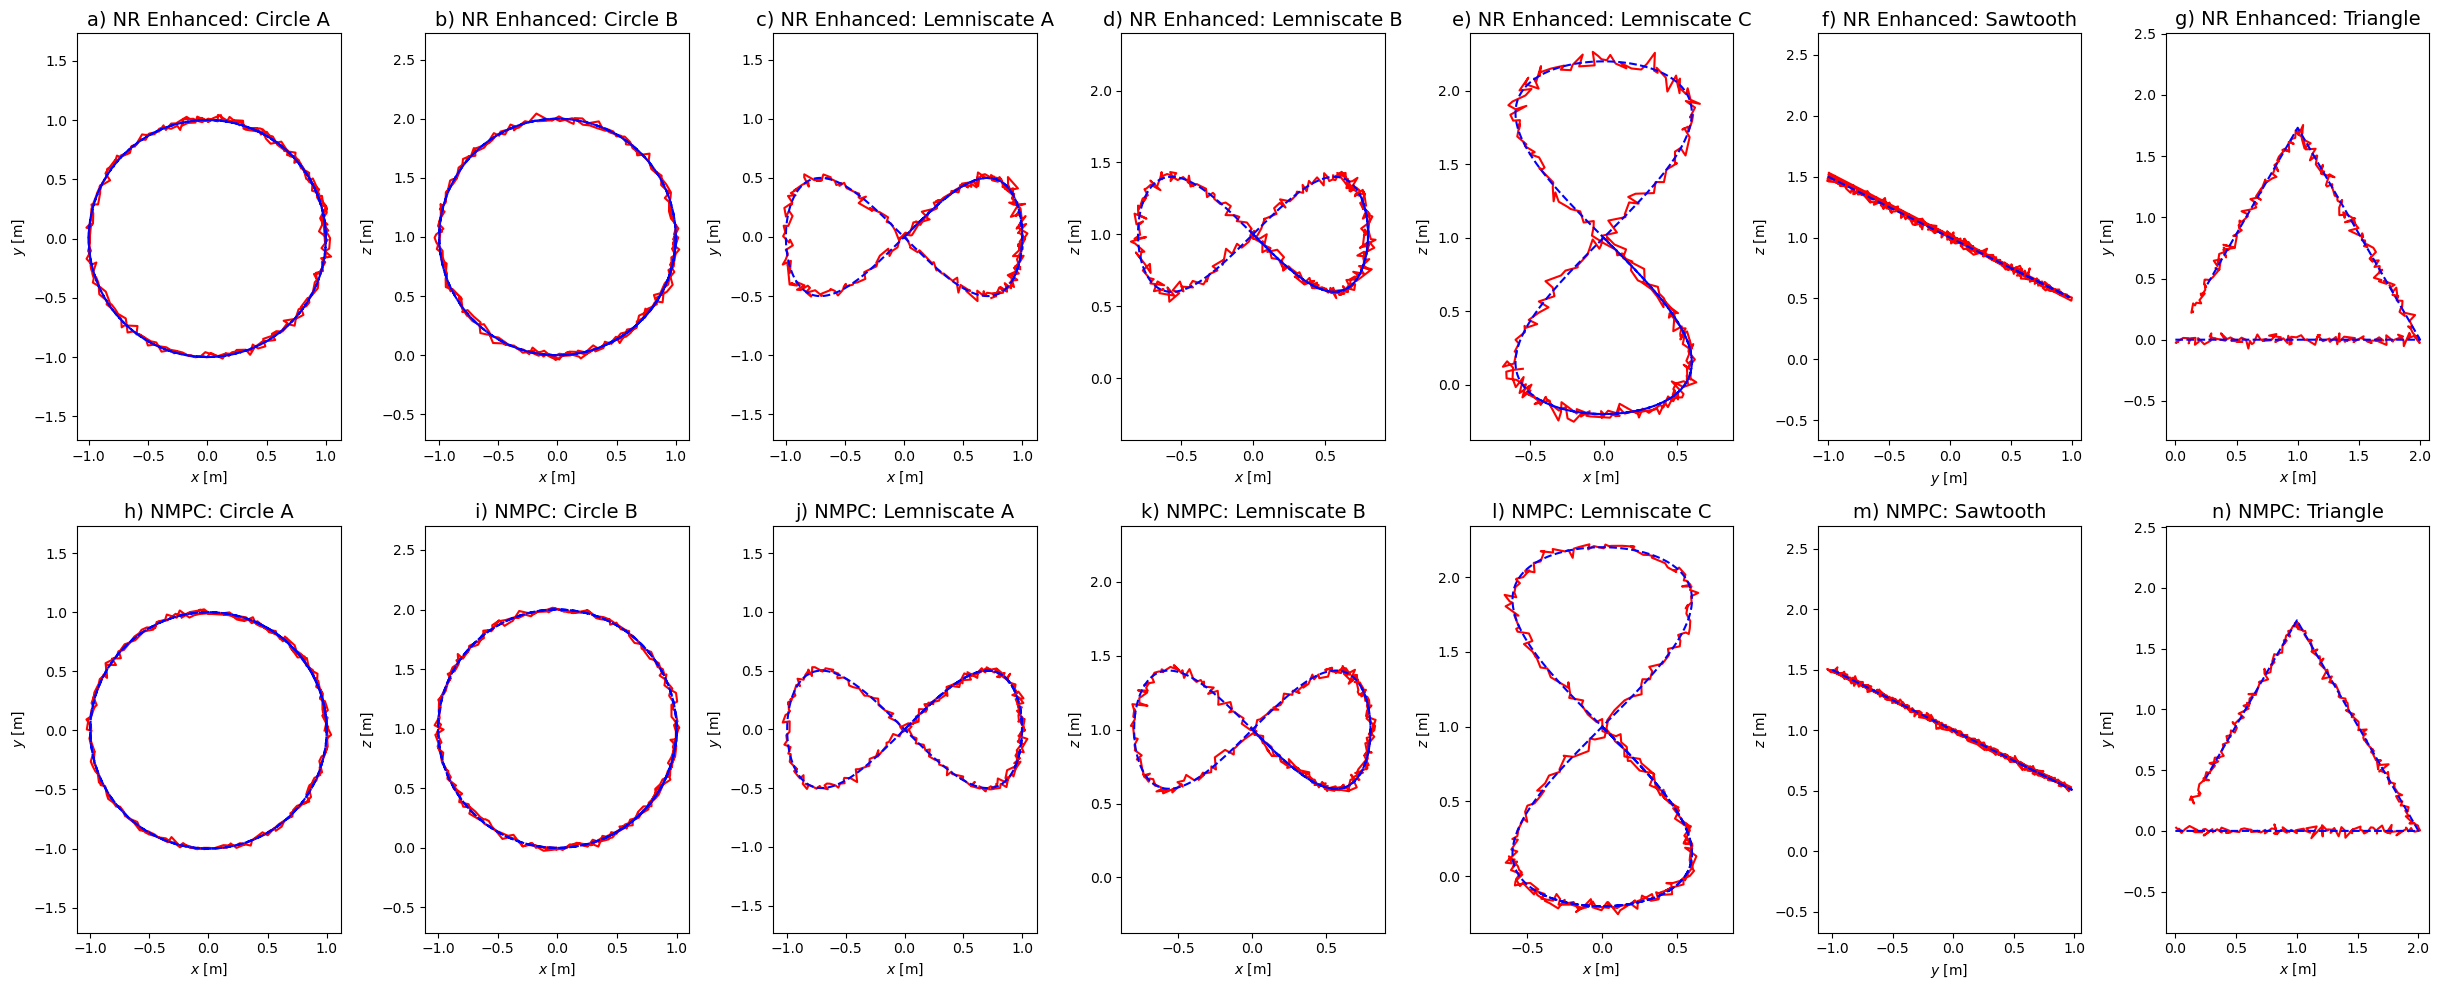

In [71]:
# Get all unique trajectories present in simulation data (filtered by included trajectories)
sim_trajectories = set()
sim_trajectories.update(organized_data['Simulation'][NR_CONTROLLER_CHOICE].keys())
sim_trajectories.update(organized_data['Simulation']['MPC'].keys())

# Filter to only included trajectories
sim_trajectories = sim_trajectories.intersection(INCLUDED_TRAJECTORIES)

# Define preferred order (only included trajectories)
preferred_order = ['Circle H', 'Circle V', 'Fig8 H', 'Fig8 VS', 'Fig8 VT', 'Sawtooth', 'Triangle']
sim_traj_ordered = [t for t in preferred_order if t in sim_trajectories]

# Add any remaining trajectories not in preferred order
for t in sorted(sim_trajectories):
    if t not in sim_traj_ordered:
        sim_traj_ordered.append(t)

print(f"Simulation Trajectories ({len(sim_traj_ordered)}): {sim_traj_ordered}")

if len(sim_traj_ordered) > 0:
    fig_sim = plot_controller_comparison_grid(
        organized_data['Simulation'],
        NR_CONTROLLER_CHOICE,
        sim_traj_ordered,
        'Simulation',
        figsize=(3.5 * len(sim_traj_ordered), 10),
        title_fontsize=subfigure_title_fontsize,
        tick_fontsize=tick_size,
        show_grid=show_gridlines
    )
    
    if fig_sim is not None:
        save_path = f"{output_path}simulation_comparison.pdf"
        fig_sim.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"\\nSaved: {save_path}")
        plt.show()
else:
    print("No simulation data available for comparison")

## 7. Hardware Comparison

Compare NR vs NMPC controllers on hardware.

Hardware Trajectories (7): ['Circle H', 'Circle V', 'Fig8 H', 'Fig8 VS', 'Fig8 VT', 'Sawtooth', 'Triangle']
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning

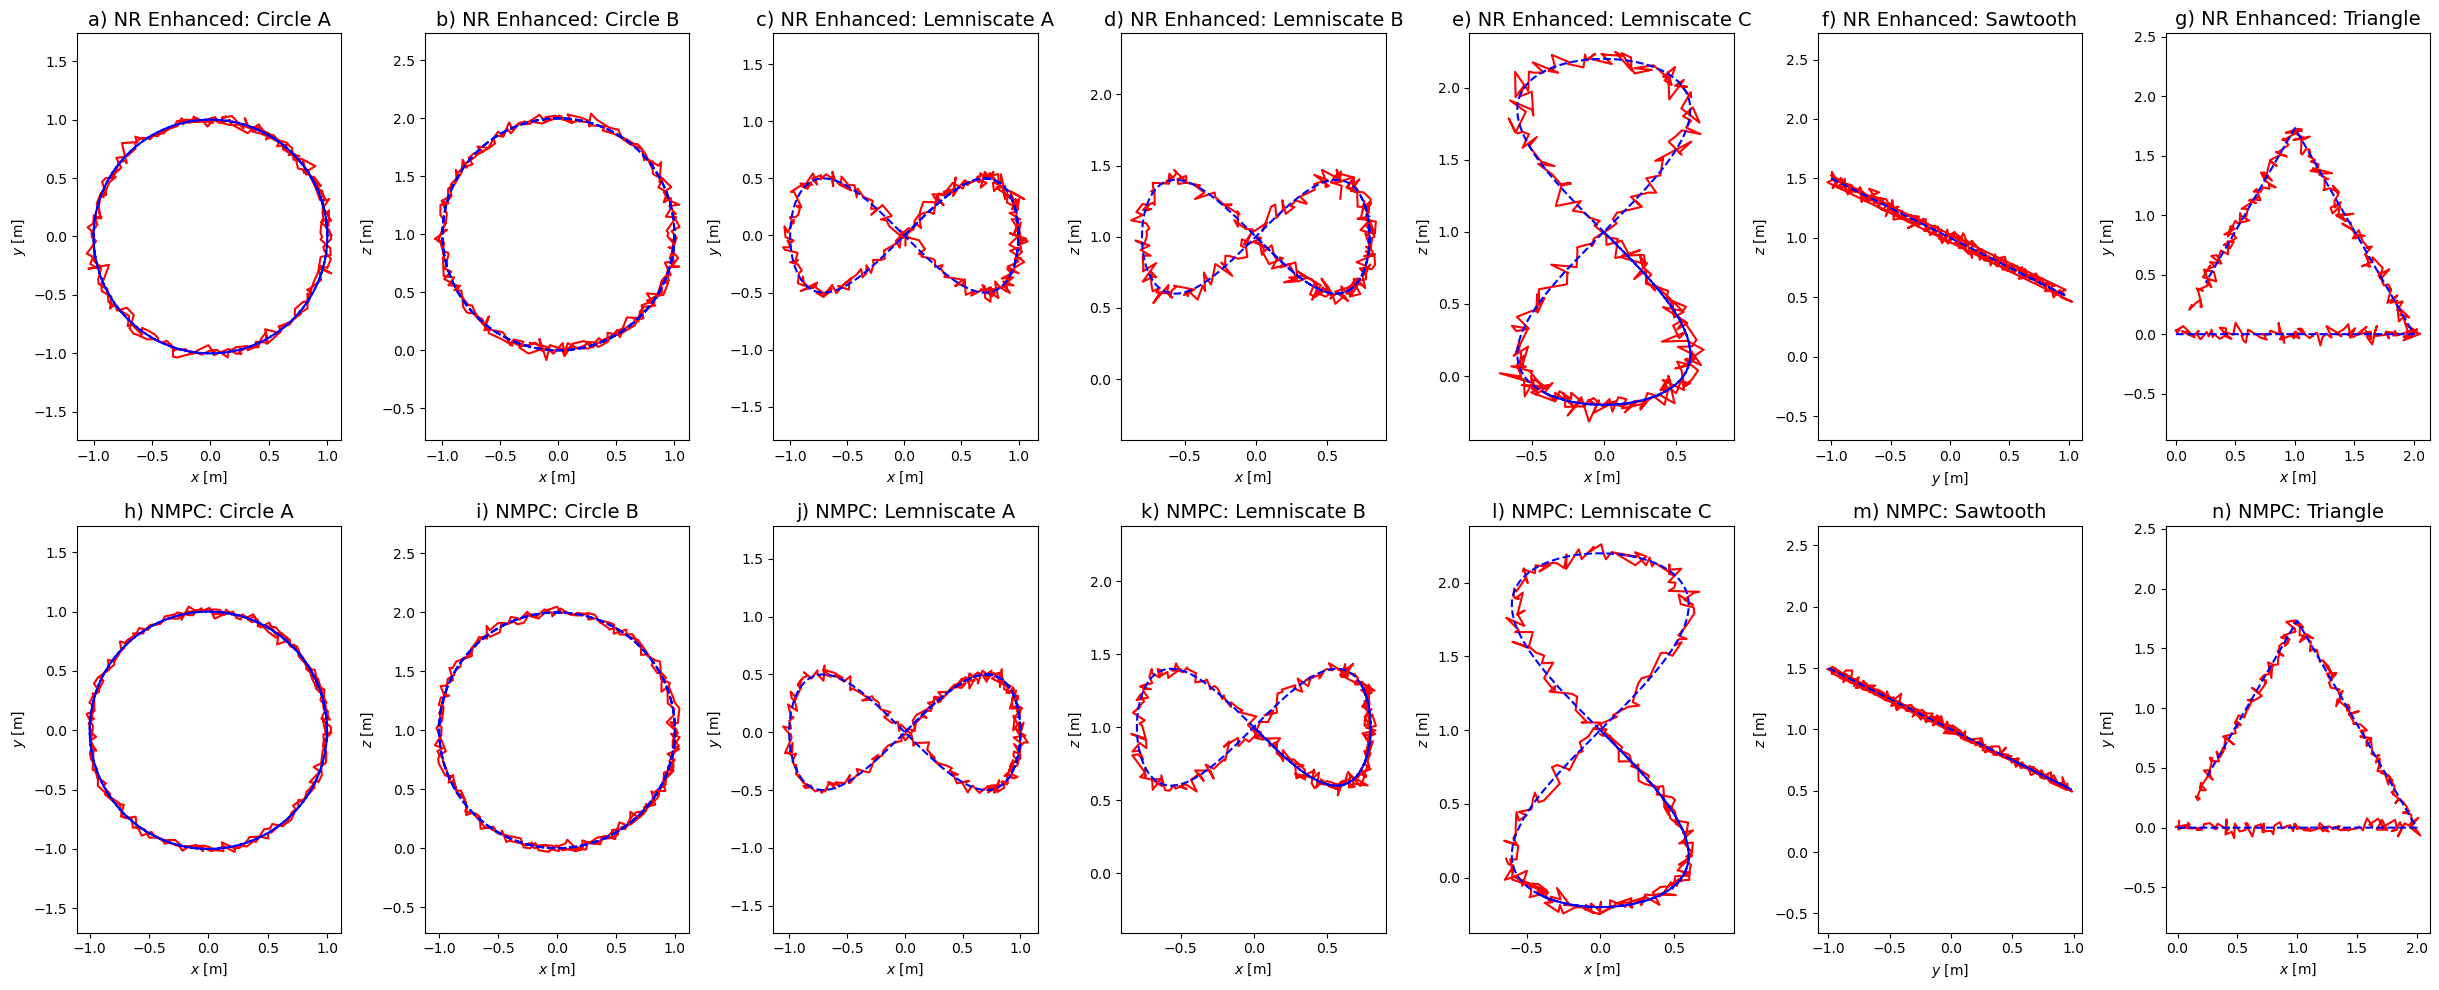

In [72]:
# Get all unique trajectories present in hardware data (filtered by included trajectories)
hw_trajectories = set()
hw_trajectories.update(organized_data['Hardware'][NR_CONTROLLER_CHOICE].keys())
hw_trajectories.update(organized_data['Hardware']['MPC'].keys())

# Filter to only included trajectories
hw_trajectories = hw_trajectories.intersection(INCLUDED_TRAJECTORIES)

# Use same preferred order
hw_traj_ordered = [t for t in preferred_order if t in hw_trajectories]

# Add any remaining trajectories not in preferred order
for t in sorted(hw_trajectories):
    if t not in hw_traj_ordered:
        hw_traj_ordered.append(t)

print(f"Hardware Trajectories ({len(hw_traj_ordered)}): {hw_traj_ordered}")

if len(hw_traj_ordered) > 0:
    fig_hw = plot_controller_comparison_grid(
        organized_data['Hardware'],
        NR_CONTROLLER_CHOICE,
        hw_traj_ordered,
        'Hardware',
        figsize=(3.5 * len(hw_traj_ordered), 10),
        title_fontsize=subfigure_title_fontsize,
        tick_fontsize=tick_size,
        show_grid=show_gridlines
    )
    
    if fig_hw is not None:
        save_path = f"{output_path}hardware_comparison.pdf"
        fig_hw.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"\\nSaved: {save_path}")
        plt.show()
else:
    print("No hardware data available for comparison")

## 8. Summary Statistics

Compare RMSE statistics across controllers and platforms.

In [73]:
# Collect RMSE statistics
summary_data = []

for platform in ['Simulation', 'Hardware']:
    for controller in [NR_CONTROLLER_CHOICE, 'MPC']:
        for traj_name, data_info in organized_data[platform][controller].items():
            # Only include trajectories in our filter
            if traj_name not in INCLUDED_TRAJECTORIES:
                continue
                
            df = data_info['df']
            metadata = data_info['metadata']
            
            # Apply transformations
            df_temp = df.copy()
            df_temp['z'] = -df_temp['z']
            df_temp['z_ref'] = -df_temp['z_ref']
            df_temp = align_reference_to_actual(df_temp, sampling_rate=10.0)
            
            rmse = calculate_position_rmse(df_temp, flip_z=False, align_lookahead=False)
            pub_name = get_publication_name(traj_name, metadata)
            
            if pub_name is not None:  # Only include if it has a publication name
                summary_data.append({
                    'Platform': platform,
                    'Controller': controller,
                    'Trajectory': pub_name,
                    'RMSE (m)': rmse
                })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

if len(summary_df) > 0:
    print("\\n" + "="*80)
    print("RMSE Summary")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    # Save to CSV
    summary_csv_path = f"{output_path}controller_comparison_rmse.csv"
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"\\nSaved: {summary_csv_path}")
    
    # Calculate mean RMSE by controller and platform
    print("\\n" + "="*80)
    print("Mean RMSE by Controller and Platform")
    print("="*80)
    mean_rmse = summary_df.groupby(['Platform', 'Controller'])['RMSE (m)'].mean()
    print(mean_rmse.to_string())
else:
    print("No data available for summary statistics")

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by

## Summary

This notebook provides controller-to-controller comparison visualizations:

### Features:
- **Platform Separation**: Separate plots for Simulation and Hardware
- **Matched Trajectories**: Top row (NR) and bottom row (NMPC) show same trajectories
- **Automatic Plane Detection**: Each trajectory uses the optimal 2D projection
- **Publication Names**: Trajectories labeled with publication-ready names
- **RMSE Metrics**: Each subplot shows position RMSE for quick comparison

### Output Files:
- `output/simulation_comparison.pdf` - Simulation comparison grid
- `output/hardware_comparison.pdf` - Hardware comparison grid
- `output/controller_comparison_rmse.csv` - RMSE summary table

### Customization:
- Change `NR_CONTROLLER_CHOICE` in the configuration cell to switch between NR Standard and NR Enhanced
- Modify `TRAJECTORY_MAP` to adjust trajectory name mappings
- Adjust `preferred_order` to change the column ordering

### Next Steps:
1. Place your log files in `log_files/` with proper metadata columns
2. Choose your NR controller in the configuration cell
3. Run all cells to generate comparison plots
4. Use the generated PDFs in your publication